# Check angle distribution after 7m distance but BEFORE decision

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.stats import iqr

In [3]:
from pp_utils.core import generate_data_path_dict, MISC_PARAMS
from pp_utils.file_handling import df_main_loader
from pp_utils import utils
import pp_utils.inspection_angle as ia

In [4]:
import pickle

## Set paths, load main info df and clusters

In [5]:
data_path = generate_data_path_dict(Path("../data_processed/"))
raw_path = Path("../data_raw/")

### Data and output path

In [6]:
output_path = data_path["main"] / "data_summary"
tp_path = output_path / "trial_processor_object"

In [7]:
fig_path = Path("../figs")
if not fig_path.exists():
    fig_path.mkdir()

### Load main dataframe

In [8]:
df_main = df_main_loader(
    folder=data_path["info_csv"], filename="main_info_append_09.csv",
)

### Load clustering results

In [9]:
with open(output_path / "clustering_7_rostrum_only.pickle", "rb") as filein:
    cluster_fnameprefix_7 = pickle.load(filein)

### Load compiled trial info and track portion

In [10]:
df_summary = pd.read_csv(output_path / "data_summary_all.csv", index_col=0)

In [11]:
with open(output_path / "track_portion_all.pickle", "rb") as filein:
    df_track_portion_all = pickle.load(filein)

## Sort clusters

### 7clusters

In [12]:
# Clean up clusters
# 0: TC-straight, 1: TC-very curved, 2: TC-curved (need to change sequence to: 0-2-1)
# 3: CT-very curved, 4: CT-curved, 6: CT-straight (need to change sequence to: 6-4-3)
df_cluster_7 = []
for seq, fp_list in enumerate(cluster_fnameprefix_7):
    df_sel = utils.sort_df_in_cluster(fp_list, df_summary)
    df_cluster_7.append(df_sel)

In [13]:
# Change sequence
new_seq = [0, 2, 1, 6, 4, 3]
df_cluster_clean_7 = []
for seq in new_seq:
    df_cluster_clean_7.append(df_cluster_7[seq])

In [14]:
# Sanity check that we've swapped things correctly
print([len(df) for df in df_cluster_7])
print([len(df) for df in df_cluster_clean_7])

[16, 9, 16, 6, 8, 1, 23]
[16, 16, 9, 23, 8, 6]


In [15]:
CLUSTER_STR_7 = [
    "R+/Straight", "R+/Curved-1", "R+/Curved-2",
    "L+/Straight", "L+/Curved-1", "L+/Curved-2"
]

## Gather data for all clicks before last scan

In [16]:
# Click RL threshold
MISC_PARAMS["th_RL"]

140

### Functions

In [17]:
def get_clicks(trial_idx, th_range=7):
    # Load TrialProcessor object
    tp_obj_fname = tp_path / f"trial_{trial_idx:03d}.pickle"
    with open(tp_obj_fname, "rb") as filein:
        tp = pickle.load(filein)

    # Time when animal reaching range threshold
    time_range_th = utils.get_time_range_threshold(
        df_tr=tp.df_track.dropna(subset=["DTAG_dist_elliptical"]).copy(),
        th_range=th_range
    )
    
    # Filter out only clicks during the last scan
    df_ch0 = utils.filter_clicks_close(
        df_h=tp.df_hydro_ch0.copy(),
        th_RL=MISC_PARAMS["th_RL"],
        time_range_th=time_range_th,
        time_decision=tp.last_scan_end,
    )
    df_ch1 = utils.filter_clicks_close(
        df_h=tp.df_hydro_ch1.copy(),
        th_RL=MISC_PARAMS["th_RL"],
        time_range_th=time_range_th,
        time_decision=tp.last_scan_end,
    )

    # Print if decision made before reaching range threshold
    if tp.last_scan_end < tp.last_scan_start:
        print(f"Trial {trial_idx}: last scan start/end time invalid!")

    # Check if any df is empty
    if isinstance(df_ch0, pd.DataFrame) and len(df_ch0) == 0:
        print(f"Trial {trial_idx}: df_ch0 is empty")
    if isinstance(df_ch1, pd.DataFrame) and len(df_ch1) == 0:
        print(f"Trial {trial_idx}: df_ch1 is empty")
    
    return df_ch0, df_ch1

In [18]:
def get_trial_angle_dist(
    trial_idx, col_name="enso_angle", **kwargs
):
    """
    kwargs include:
        - enso_bin
        - time_binning
        - count_type
        - bin_delta
        - density
    
    Use col_name="enso_angle_flip" to flip enso_angle first before binning
    """
    df_ch0, df_ch1 = get_clicks(trial_idx)

    # Create a column for flipped angle if specified
    if col_name == "enso_angle_flip":
        df_ch0["enso_angle_flip"] = ia.enso2spheroid_angle(df_ch0["enso_angle"])
        df_ch1["enso_angle_flip"] = ia.enso2spheroid_angle(df_ch1["enso_angle"])
    
    # Get angle span
    ch0_angle_span = df_ch0["enso_angle"].max() - df_ch0["enso_angle"].min()
    ch1_angle_span = df_ch1["enso_angle"].max() - df_ch1["enso_angle"].min()

    # Get distribution
    ch0_dist = ia.get_angle_dist(df_click=df_ch0, col_name=col_name, **kwargs)
    ch1_dist = ia.get_angle_dist(df_click=df_ch1, col_name=col_name, **kwargs)
    
    return ch0_dist, ch1_dist, ch0_angle_span, ch1_angle_span

### Set up histgram params

In [19]:
enso_bin = np.arange(-90, 95, 3.75)
x_hist = (enso_bin[:-1] + enso_bin[1:])/2

In [20]:
enso_bin_size = enso_bin[1] - enso_bin[0]

In [21]:
binning_params = {
    "angle_bin": enso_bin,
    "time_binning": False,
    "density": False,
}

In [22]:
plot_params_ch0 = {
    "alpha": 0.5,
    "edgecolor": "k",
    "facecolor": "C0",
    "linewidth": 1
}
plot_params_ch1 = plot_params_ch0.copy()
plot_params_ch1["facecolor"] = "C1"

In [23]:
# Scenarios
SCENARIO_STR = [
    "TC1", "TC2", "TC3", "TC4",
    "CT1", "CT2", "CT3", "CT4",
]

## All clusters

R+/Straight
----- Trial index=242 ----------
Ch1 angle span=7.707 deg
----- Trial index=223 ----------
Ch1 angle span=9.201 deg
----- Trial index=238 ----------
Ch1 angle span=1.391 deg
----- Trial index=96 ----------
Trial 96: df_ch0 is empty
Ch1 angle span=4.310 deg
----- Trial index=97 ----------
Trial 97: df_ch0 is empty
Trial 97: df_ch1 is empty
Ch1 angle span=nan deg
----- Trial index=236 ----------
Ch1 angle span=16.655 deg
----- Trial index=134 ----------
Trial 134: df_ch0 is empty
Ch1 angle span=0.446 deg
----- Trial index=215 ----------
Ch1 angle span=6.150 deg
----- Trial index=132 ----------
Ch1 angle span=6.353 deg
----- Trial index=112 ----------
Ch1 angle span=22.687 deg
----- Trial index=178 ----------
Ch1 angle span=1.324 deg
----- Trial index=89 ----------
Ch1 angle span=5.694 deg
----- Trial index=191 ----------
Ch1 angle span=3.999 deg
----- Trial index=127 ----------
Ch1 angle span=6.014 deg
----- Trial index=85 ----------
Ch1 angle span=9.458 deg
----- Trial index

/var/folders/1m/8nxc8r_900778tkhqfgh0nqh0000gn/T/ipykernel_79714/341603838.py:39: RuntimeWarning: invalid value encountered in divide
  ch1_dist_all_mtx_norm = (ch1_dist_all_mtx.T / ch1_dist_all_mtx.sum(axis=1)).T


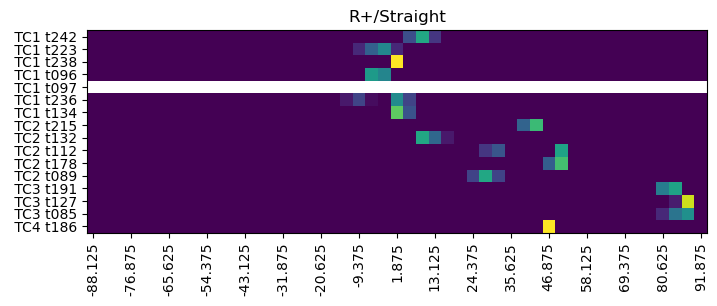

R+/Curved-1
----- Trial index=114 ----------
Ch1 angle span=5.670 deg
----- Trial index=80 ----------
Ch1 angle span=7.988 deg
----- Trial index=155 ----------
Ch1 angle span=3.897 deg
----- Trial index=216 ----------
Ch1 angle span=13.703 deg
----- Trial index=221 ----------
Ch1 angle span=7.145 deg
----- Trial index=135 ----------
Ch1 angle span=3.859 deg
----- Trial index=138 ----------
Ch1 angle span=2.520 deg
----- Trial index=179 ----------
Ch1 angle span=11.099 deg
----- Trial index=189 ----------
Ch1 angle span=18.354 deg
----- Trial index=183 ----------
Ch1 angle span=5.614 deg
----- Trial index=125 ----------
Ch1 angle span=13.628 deg
----- Trial index=139 ----------
Ch1 angle span=1.816 deg
----- Trial index=123 ----------
Ch1 angle span=16.065 deg
----- Trial index=240 ----------
Ch1 angle span=11.737 deg
----- Trial index=246 ----------
Ch1 angle span=13.010 deg
----- Trial index=188 ----------
Ch1 angle span=37.740 deg
Buzz initiated during last scan!


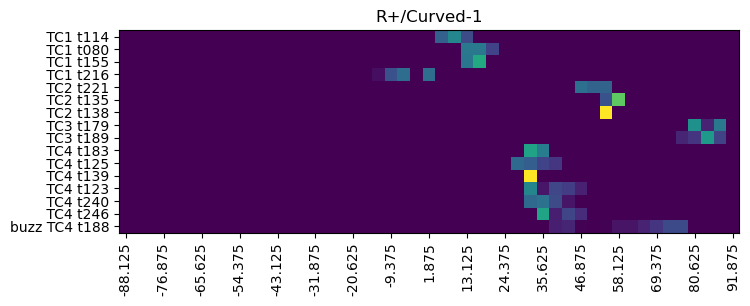

R+/Curved-2
----- Trial index=78 ----------
Ch1 angle span=22.300 deg
Buzz initiated during last scan!
----- Trial index=92 ----------
Ch1 angle span=20.214 deg
Buzz initiated during last scan!
----- Trial index=159 ----------
Ch1 angle span=3.590 deg
----- Trial index=129 ----------
Ch1 angle span=40.440 deg
Buzz initiated during last scan!
----- Trial index=218 ----------
Ch1 angle span=53.799 deg
----- Trial index=176 ----------
Ch1 angle span=3.418 deg
----- Trial index=161 ----------
Ch1 angle span=17.879 deg
Buzz initiated during last scan!
----- Trial index=212 ----------
Ch1 angle span=13.941 deg
----- Trial index=239 ----------
Ch1 angle span=33.753 deg
Buzz initiated during last scan!


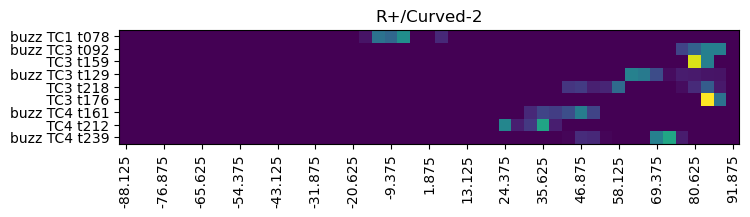

L+/Straight
----- Trial index=131 ----------
Ch1 angle span=6.019 deg
----- Trial index=84 ----------
Ch1 angle span=10.238 deg
----- Trial index=184 ----------
Ch1 angle span=4.478 deg
----- Trial index=111 ----------
Ch1 angle span=5.815 deg
----- Trial index=86 ----------
Ch1 angle span=4.947 deg
----- Trial index=237 ----------
Ch1 angle span=5.758 deg
----- Trial index=187 ----------
Ch1 angle span=2.097 deg
----- Trial index=91 ----------
Ch1 angle span=6.230 deg
----- Trial index=241 ----------
Ch1 angle span=7.842 deg
----- Trial index=243 ----------
Ch1 angle span=3.014 deg
----- Trial index=154 ----------
Ch1 angle span=12.423 deg
----- Trial index=160 ----------
Ch1 angle span=7.310 deg
----- Trial index=133 ----------
Ch1 angle span=9.875 deg
----- Trial index=141 ----------
Ch1 angle span=1.587 deg
----- Trial index=130 ----------
Ch1 angle span=4.351 deg
----- Trial index=213 ----------
Ch1 angle span=12.467 deg
----- Trial index=153 ----------
Ch1 angle span=8.654 deg
--

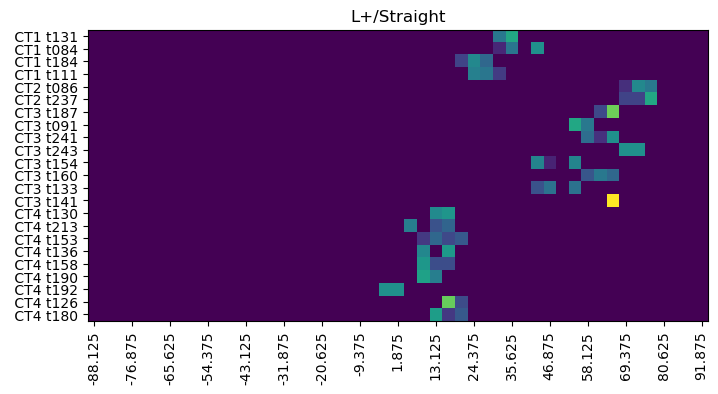

L+/Curved-1
----- Trial index=90 ----------
Ch1 angle span=15.505 deg
----- Trial index=219 ----------
Ch1 angle span=10.098 deg
Buzz initiated during last scan!
----- Trial index=207 ----------
Ch1 angle span=25.065 deg
----- Trial index=235 ----------
Ch1 angle span=10.635 deg
----- Trial index=79 ----------
Ch1 angle span=8.478 deg
----- Trial index=220 ----------
Ch1 angle span=4.777 deg
----- Trial index=181 ----------
Ch1 angle span=6.808 deg
----- Trial index=222 ----------
Ch1 angle span=7.321 deg


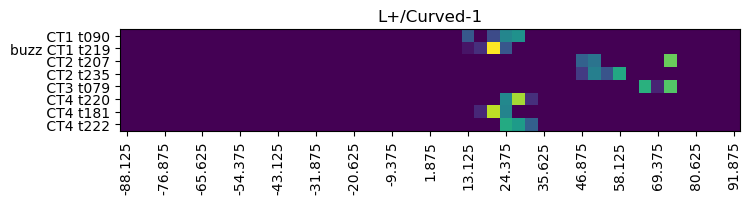

L+/Curved-2
----- Trial index=82 ----------
Ch1 angle span=35.341 deg
----- Trial index=217 ----------
Ch1 angle span=31.104 deg
----- Trial index=117 ----------
Ch1 angle span=20.539 deg
----- Trial index=182 ----------
Ch1 angle span=55.762 deg
Buzz initiated during last scan!
----- Trial index=121 ----------
Ch1 angle span=7.405 deg
----- Trial index=205 ----------
Ch1 angle span=3.398 deg


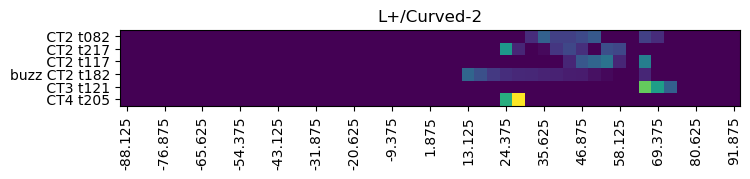

In [24]:
for cluster_idx in range(6):
    df_cluster = df_cluster_clean_7[cluster_idx]
    print(CLUSTER_STR_7[cluster_idx])
    for tca in SCENARIO_STR:
        df_tca = df_cluster[df_cluster["TARGET_ANGLE"] == tca]
        # print(f"{tca}: {len(df_tca)} trials in this cluster")

    str_all = []
    ch1_dist_all = []
    buzz_str = ""
    for tca in SCENARIO_STR:
        df_tca = df_cluster[df_cluster["TARGET_ANGLE"] == tca]
        if len(df_tca) == 0:
            continue

        # if trials exist under this scenario
        for trial_idx in df_tca.index:
            print(f"----- Trial index={trial_idx} ----------")
            ch0_dist, ch1_dist, ch0_angle_span, ch1_angle_span = get_trial_angle_dist(
                trial_idx,
                col_name="enso_angle_flip",
                **binning_params,
            )
            print(f"Ch1 angle span={ch1_angle_span:3.3f} deg")

            # If buzz initiated during last scan
            if df_summary.loc[trial_idx]["time_buzz_onset_clean"] < df_summary.loc[trial_idx]["time_decision"]:
                print("Buzz initiated during last scan!")
                buzz_str = "buzz"
            else:
                buzz_str = ""

            ch1_dist_all.append(ch1_dist)

            str_trial = f"{buzz_str} {tca} t{trial_idx:03d}"
            str_all.append(str_trial)

    ch1_dist_all_mtx = np.array(ch1_dist_all)
    ch1_dist_all_mtx_norm = (ch1_dist_all_mtx.T / ch1_dist_all_mtx.sum(axis=1)).T

    plt.figure(figsize=(8, 5))
    plt.imshow(ch1_dist_all_mtx_norm)
    plt.yticks(np.arange(ch1_dist_all_mtx_norm.shape[0]), str_all)
    plt.xticks(np.arange(ch1_dist_all_mtx_norm.shape[1])[::3], x_hist[::3], rotation=90)
    plt.title(CLUSTER_STR_7[cluster_idx])
    plt.show()

R+/Straight
----- Trial index=242 ----------
Ch1 angle span=7.707 deg
----- Trial index=223 ----------
Ch1 angle span=9.201 deg
----- Trial index=238 ----------
Ch1 angle span=1.391 deg
----- Trial index=96 ----------
Trial 96: df_ch0 is empty
Trial 96: df_ch0 is empty
Ch1 angle span=4.310 deg
----- Trial index=97 ----------
Trial 97: df_ch0 is empty
Trial 97: df_ch1 is empty
Trial 97: df_ch0 is empty
Trial 97: df_ch1 is empty
Ch1 angle span=nan deg
----- Trial index=236 ----------
Ch1 angle span=16.655 deg
----- Trial index=134 ----------
Trial 134: df_ch0 is empty
Trial 134: df_ch0 is empty
Ch1 angle span=0.446 deg
----- Trial index=215 ----------
Ch1 angle span=6.150 deg
----- Trial index=132 ----------
Ch1 angle span=6.353 deg
----- Trial index=112 ----------
Ch1 angle span=22.687 deg
----- Trial index=178 ----------
Ch1 angle span=1.324 deg
----- Trial index=89 ----------
Ch1 angle span=5.694 deg
----- Trial index=191 ----------
Ch1 angle span=3.999 deg
----- Trial index=127 -----

/var/folders/1m/8nxc8r_900778tkhqfgh0nqh0000gn/T/ipykernel_79714/3588416568.py:63: RuntimeWarning: invalid value encountered in divide
  ch1_dist_all_mtx_norm = (ch1_dist_all_mtx.T / ch1_dist_all_mtx.sum(axis=1)).T
/var/folders/1m/8nxc8r_900778tkhqfgh0nqh0000gn/T/ipykernel_79714/3588416568.py:63: RuntimeWarning: invalid value encountered in divide
  ch1_dist_all_mtx_norm = (ch1_dist_all_mtx.T / ch1_dist_all_mtx.sum(axis=1)).T
/var/folders/1m/8nxc8r_900778tkhqfgh0nqh0000gn/T/ipykernel_79714/3588416568.py:63: RuntimeWarning: invalid value encountered in divide
  ch1_dist_all_mtx_norm = (ch1_dist_all_mtx.T / ch1_dist_all_mtx.sum(axis=1)).T


Ch1 angle span=13.628 deg
----- Trial index=139 ----------
Ch1 angle span=1.816 deg
----- Trial index=123 ----------
Ch1 angle span=16.065 deg
----- Trial index=240 ----------
Ch1 angle span=11.737 deg
----- Trial index=246 ----------
Ch1 angle span=13.010 deg
----- Trial index=188 ----------
Ch1 angle span=37.740 deg
Buzz initiated during last scan!
R+/Curved-2
----- Trial index=78 ----------
Ch1 angle span=22.300 deg
Buzz initiated during last scan!
----- Trial index=92 ----------
Ch1 angle span=20.214 deg
Buzz initiated during last scan!
----- Trial index=159 ----------
Ch1 angle span=3.590 deg
----- Trial index=129 ----------
Ch1 angle span=40.440 deg
Buzz initiated during last scan!
----- Trial index=218 ----------
Ch1 angle span=53.799 deg
----- Trial index=176 ----------
Ch1 angle span=3.418 deg
----- Trial index=161 ----------
Ch1 angle span=17.879 deg
Buzz initiated during last scan!
----- Trial index=212 ----------
Ch1 angle span=13.941 deg
----- Trial index=239 ----------
Ch

/var/folders/1m/8nxc8r_900778tkhqfgh0nqh0000gn/T/ipykernel_79714/3588416568.py:63: RuntimeWarning: invalid value encountered in divide
  ch1_dist_all_mtx_norm = (ch1_dist_all_mtx.T / ch1_dist_all_mtx.sum(axis=1)).T
/var/folders/1m/8nxc8r_900778tkhqfgh0nqh0000gn/T/ipykernel_79714/3588416568.py:63: RuntimeWarning: invalid value encountered in divide
  ch1_dist_all_mtx_norm = (ch1_dist_all_mtx.T / ch1_dist_all_mtx.sum(axis=1)).T
/var/folders/1m/8nxc8r_900778tkhqfgh0nqh0000gn/T/ipykernel_79714/3588416568.py:63: RuntimeWarning: invalid value encountered in divide
  ch1_dist_all_mtx_norm = (ch1_dist_all_mtx.T / ch1_dist_all_mtx.sum(axis=1)).T


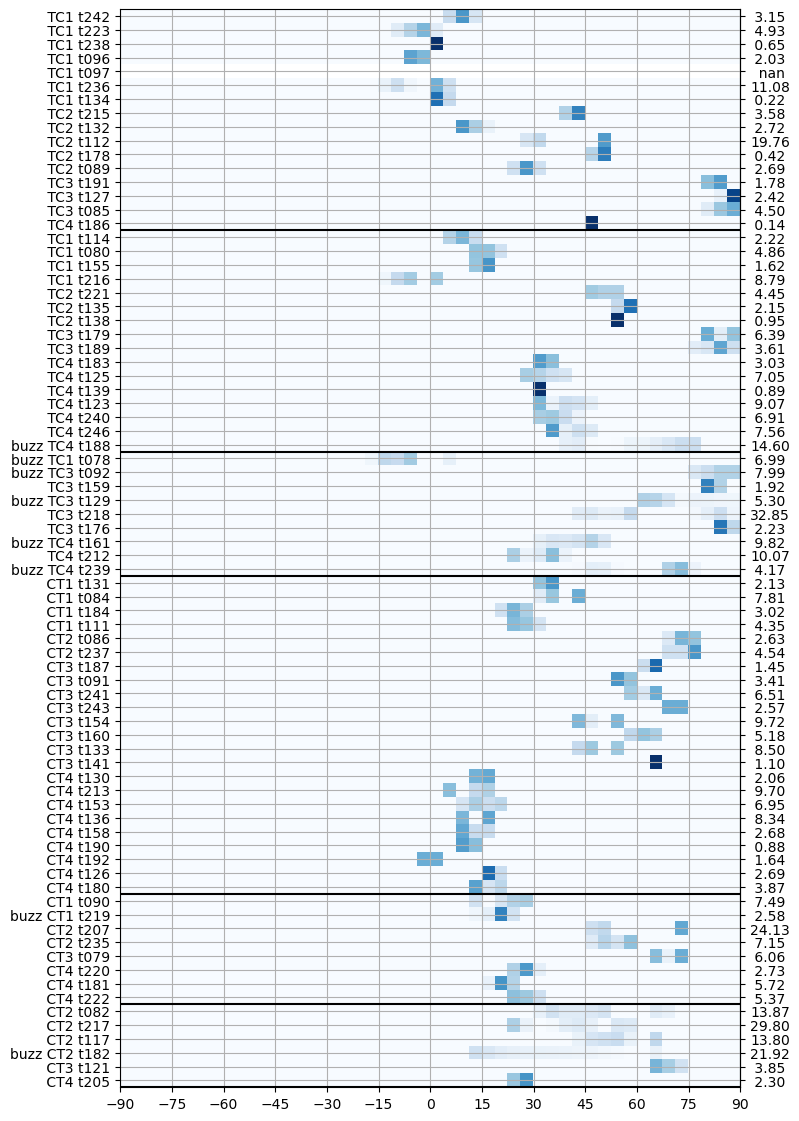

In [25]:
str_all = []
ch1_dist_all = []
iqr_cluster = dict()
iqr_all = []
iqr_buzz_all = []
iqr_regclick_all = []
iqr_str_all = []
trial_idx_all = []
buzz_str = ""
buzz_trial_idx = []
cluster_cut = []

for cluster_idx in range(6):
    df_cluster = df_cluster_clean_7[cluster_idx]
    print(CLUSTER_STR_7[cluster_idx])

    cluster_cut.append(len(df_cluster))
    iqr_cluster[CLUSTER_STR_7[cluster_idx]] = []  # store iqr within cluster

    for tca in SCENARIO_STR:
        df_tca = df_cluster[df_cluster["TARGET_ANGLE"] == tca]
        if len(df_tca) == 0:
            continue

        # if trials exist under this scenario
        for trial_idx in df_tca.index:
            print(f"----- Trial index={trial_idx} ----------")

            # get clicks
            _, df_ch1 = get_clicks(trial_idx)
            df_ch1["enso_angle_flip"] = ia.enso2spheroid_angle(df_ch1["enso_angle"])

            # get click distribution
            _, ch1_dist, _, ch1_angle_span = get_trial_angle_dist(
                trial_idx,
                col_name="enso_angle_flip",
                **binning_params,
            )
            print(f"Ch1 angle span={ch1_angle_span:3.3f} deg")

            # If buzz initiated during last scan
            if df_summary.loc[trial_idx]["time_buzz_onset_clean"] < df_summary.loc[trial_idx]["time_decision"]:
                print("Buzz initiated during last scan!")
                buzz_str = "buzz"
                buzz_trial_idx.append(trial_idx)
                iqr_buzz_all.append(iqr(df_ch1["enso_angle_flip"], nan_policy="omit"))
            else:
                buzz_str = ""
                iqr_regclick_all.append(iqr(df_ch1["enso_angle_flip"], nan_policy="omit"))

            ch1_dist_all.append(ch1_dist)

            trial_idx_all.append(trial_idx)

            str_trial = f"{buzz_str} {tca} t{trial_idx:03d}"
            str_all.append(str_trial)

            iqr_cluster[CLUSTER_STR_7[cluster_idx]].append(iqr(df_ch1["enso_angle_flip"], nan_policy="omit"))
            iqr_all.append(iqr(df_ch1["enso_angle_flip"], nan_policy="omit"))
            iqr_str_all.append(f"{iqr(df_ch1['enso_angle_flip'], nan_policy='omit'):5.2f}")

    ch1_dist_all_mtx = np.array(ch1_dist_all)
    ch1_dist_all_mtx_norm = (ch1_dist_all_mtx.T / ch1_dist_all_mtx.sum(axis=1)).T

plt.figure(figsize=(8, 14))
plt.imshow(
    ch1_dist_all_mtx_norm,
    extent=(-90, 93.75, 0, ch1_dist_all_mtx_norm.shape[0]),
    aspect="auto",
    origin="lower",
    cmap="Blues"
)
plt.yticks(np.arange(ch1_dist_all_mtx_norm.shape[0])+0.5, str_all)
plt.xticks(np.arange(-90, 100, 15))
plt.xlim(-90, 90)
plt.grid()

# Annotate iqr on the right
secax = plt.gca().secondary_yaxis('right')
secax.set_yticks(np.arange(ch1_dist_all_mtx_norm.shape[0])+0.5)
secax.set_yticklabels(iqr_str_all)

# Plot cluster cut
cluster_cut = np.cumsum(cluster_cut)
for cc in cluster_cut:
    plt.gca().axhline(y=cc, color="k")

plt.gca().invert_yaxis()
plt.show()

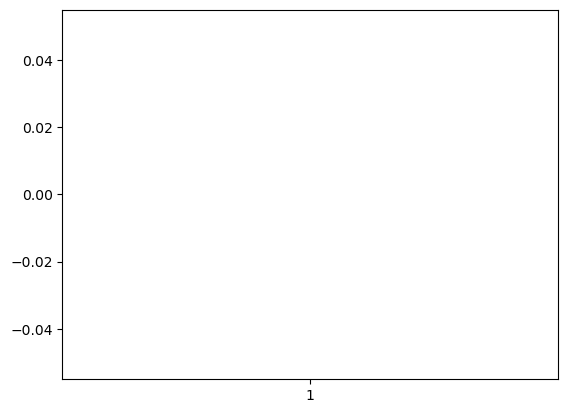

In [26]:
box_plot_dict = plt.boxplot(iqr_all)

In [27]:
[len(x) for x in iqr_cluster.values()]

[16, 16, 9, 23, 8, 6]

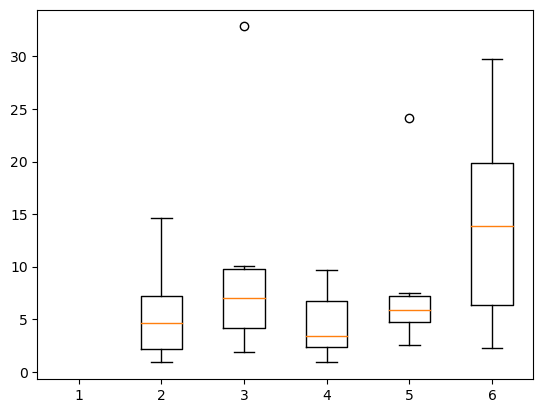

In [28]:
plt.boxplot(iqr_cluster.values())
plt.show()